In [25]:
source_name=input('Enter Source Name (format: IC_348): ')

Enter Source Name (format: IC_348): v2494_cyg


Enter group to test: 13
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 2 moving from (45.0, 0.25) to (61.750345088971414, 3.062525489627537)...
Arm 2 reached (61.750345088971414, 3.062525489627537).
Arm 7 moving from (270.0, 0.25) to (273.65354151109005, 2.321848949223412)...
Arm 7 reached (273.65354151109005, 2.321848949223412).
Arm 1 moving from (0.0, 0.25) to (4.601076898644429, 2.2551737841776727)...
Arm 1 reached (4.601076898644429, 2.2551737841776727).
Arm 5 moving from (180.0, 0.25) to (196.09463804674488, 1.4521252727205207)...
Arm 5 reached (196.09463804674488, 1.4521252727205207).
Arm 8 moving from (315.0, 0.25) to (326.1236059987651, 1.3206059408571873)...
Arm 8 reached (326.1236059987651, 1.3206059408571873).
Arm 3 moving from (90.0, 0.25) to (71.74411331981727, 0.45481279598229035)...
Arm 3 reached (71.74411331981727, 0.45481279598229035).


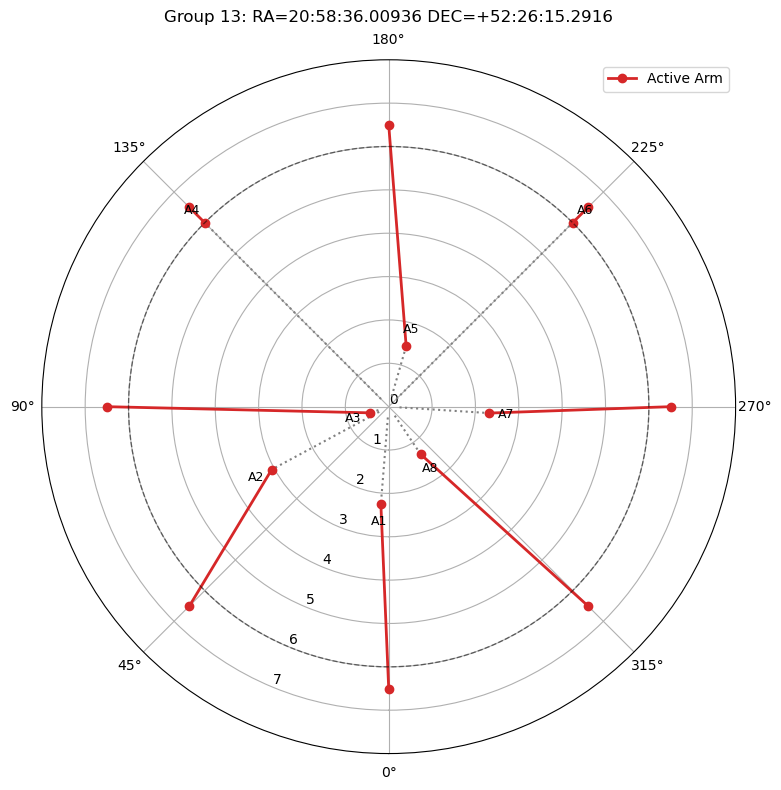

In [29]:
#Arm Positioning Simulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import nest_asyncio
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import linear_sum_assignment
from math import radians, cos, sin, sqrt
import math

# Constants
NUM_ARMS = 8
FOCAL_PLANE_RADIUS = 6
ARM_RADIUS = 6.5
THETA_STEP = 360 / NUM_ARMS
MIN_SAFE_DISTANCE = 0.3
pickup_arm_centers = [(i * THETA_STEP, ARM_RADIUS) for i in range(NUM_ARMS)]
PARKED_RADIUS = 0.25
FIXED_END_RADIUS = 6.5

# Load and Convert to Polar Coordinates
def convert_grouped_targets_to_polar(grouped_yso_path, groups_summary_path):
    grouped_df = pd.read_csv(grouped_yso_path)
    summary_df = pd.read_csv(groups_summary_path)
    grouped_polar_targets = {}

    for _, group_row in summary_df.iterrows():
        group_id = int(group_row['Group'])
        origin_coord = SkyCoord(group_row['RA_center'], group_row['DEC_center'], unit=(u.deg, u.deg))
        origin_ra_hms = origin_coord.ra.to_string(unit=u.hour, sep=':')
        origin_dec_dms = origin_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)

        group_targets = grouped_df[grouped_df['Group'] == group_id]
        polar_targets = []

        for _, row in group_targets.iterrows():
            target_coord = SkyCoord(row['RA_deg'], row['DEC_deg'], unit=(u.deg, u.deg))
            sep = origin_coord.separation(target_coord).arcmin
            pa = origin_coord.position_angle(target_coord).deg % 360
            offset_arcmin = row.get('offset_arcmin', None)

            if offset_arcmin is not None:
                if abs(sep - offset_arcmin) > 0.05:
                    print(f"⚠️ Warning: Group {group_id} Target mismatch: Calculated={sep:.3f} arcmin, Offset_Arcmin={offset_arcmin:.3f} arcmin")
            polar_targets.append((pa, sep))

        if polar_targets:
            grouped_polar_targets[group_id] = polar_targets

    return grouped_polar_targets

# Polar helpers
def polar_to_cartesian(theta_deg, r):
    theta_rad = radians(theta_deg)
    return r * cos(theta_rad), r * sin(theta_rad)

def euclidean_distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


# Adjust Distances
def adjust_distances(targets):
    adjusted_targets = []
    for i, (theta_i, r_i) in enumerate(targets):
        is_safe = True
        for j, (theta_j, r_j) in enumerate(targets):
            if i != j:
                distance = sqrt(r_i**2 + r_j**2 - 2 * r_i * r_j * cos(radians(theta_i - theta_j)))
                if distance < MIN_SAFE_DISTANCE:
                    is_safe = False
                    break
        if is_safe:
            adjusted_targets.append((theta_i, r_i))
        else:
            print(f"Target {i + 1} adjusted due to proximity.")
    return adjusted_targets

# Assign Targets to Arms
def assign_targets_to_positioners(targets):
    assignments = []
    targets = sorted(targets, key=lambda x: x[0])
    for i in range(NUM_ARMS):
        assignments.append((pickup_arm_centers[i][0], targets[i]))
    return assignments

# Assignment with Collision Avoidance and Parking
def assign_targets_with_parking(grouped_polar_targets):
    results = {}
    arm_cartesian = [polar_to_cartesian(theta, ARM_RADIUS) for theta, _ in pickup_arm_centers]

    for group_id, targets in grouped_polar_targets.items():
        adjusted_targets = adjust_distances(targets)
        num_targets = len(adjusted_targets)
        target_cartesian = [polar_to_cartesian(theta, r) for theta, r in adjusted_targets]
        arm_to_target = {}
        assigned_arms = []

        if num_targets <= NUM_ARMS:
            cost_matrix = np.zeros((NUM_ARMS, num_targets))
            for i in range(NUM_ARMS):
                for j in range(num_targets):
                    d = euclidean_distance(arm_cartesian[i], target_cartesian[j])
                    cost_matrix[i][j] = d 

            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            for arm_idx, tgt_idx in zip(row_ind, col_ind):
                if cost_matrix[arm_idx][tgt_idx] < 1e6:
                    assigned_arms.append(arm_idx)
                    arm_to_target[arm_idx] = adjusted_targets[tgt_idx]

            unused_arms = [a for a in range(NUM_ARMS) if a not in assigned_arms]
            for arm in unused_arms:
                arm_to_target[arm] = (pickup_arm_centers[arm][0], FOCAL_PLANE_RADIUS)
        else:
            print(f"⚠️ Warning: More targets than arms for Group {group_id}. Assigning first {NUM_ARMS} targets only.")
            for i in range(NUM_ARMS):
                arm_to_target[i] = adjusted_targets[i]

        results[group_id] = {
            "assignments": arm_to_target
        }

    return results

# Asynchronous Arm Movement
async def move_arm(index, start, end, results):
    theta_start, r_start = start
    theta_end, r_end = end
    steps = 100
    theta_values = np.linspace(theta_start, theta_end, steps)
    r_values = np.linspace(r_start, r_end, steps)

    print(f"Arm {index + 1} moving from {start} to {end}...")
    for theta, r in zip(theta_values, r_values):
        results[index] = (theta % 360, r)
        await asyncio.sleep(0.05)
    print(f"Arm {index + 1} reached {end}.")

async def arrange_arms_sequential(assignments):
    results = [(theta, PARKED_RADIUS) for theta, _ in pickup_arm_centers]

    # 📈 Sort arms by target radius (descending order: farther arms move first)
    arms_by_distance = sorted(assignments.items(), key=lambda x: x[1][1], reverse=True)

    for arm_index, target in arms_by_distance:
        await move_arm(arm_index, (pickup_arm_centers[arm_index][0], PARKED_RADIUS), target, results)

    return results

# Plotting
def plot_positions(initial, final, ra_center_hms, dec_center_dms, group_id=None):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    ax.set_title(f"Group {group_id}: RA={ra_center_hms} DEC={dec_center_dms}", va='bottom')


    used_indices = [i for i, (_, r) in enumerate(final) if r <= ARM_RADIUS]
    final_positions = {
        i: (float(pos[0]), float(pos[1])) if isinstance(pos, (list, tuple, np.ndarray)) else (0.0, 0.0)
        for i, pos in enumerate(final)
    }

    labels_drawn = {"Active Arm": False, "Parked Arm": False}

    for i, (theta_init, _) in enumerate(initial):
        theta_final, r_final = final_positions.get(i, (theta_init, PARKED_RADIUS))
        theta_rad = np.radians(theta_final)
        
        ax.plot([theta_rad, theta_rad], [PARKED_RADIUS, r_final], linestyle=':', linewidth=1.5, color='gray')
        color = 'tab:red' if i in used_indices else 'black'
        label = 'Active Arm' if (color == 'tab:red' and not labels_drawn['Active Arm']) else \
                'Parked Arm' if (color == 'black' and not labels_drawn['Parked Arm']) else ""

        ax.plot([np.radians(theta_init), theta_rad], [FIXED_END_RADIUS, r_final], color=color, linewidth=2, marker='o', label=label)
        ax.text(theta_rad, r_final + 0.4, f"A{i+1}", fontsize=9, ha='center', va='center')

        if label:
            labels_drawn[label] = True
    
    theta_range = np.linspace(0, 2 * np.pi, 360)
    r_boundary = np.full_like(theta_range, FOCAL_PLANE_RADIUS)
    ax.plot(theta_range, r_boundary, 'k--', linewidth=1.0, alpha=0.5)

    ax.set_rmax(FOCAL_PLANE_RADIUS + 2)
    ax.set_rticks(np.arange(0, FOCAL_PLANE_RADIUS + 2, 1))
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

#Running Simulation
async def run_simulation(grouped_yso_path, groups_summary_path, group_to_test):
    grouped_targets = convert_grouped_targets_to_polar(grouped_yso_path, groups_summary_path)
    assigned = assign_targets_with_parking(grouped_targets)

    summary_df = pd.read_csv(groups_summary_path)
    group_row = summary_df[summary_df['Group'] == group_to_test].iloc[0]

    origin_coord = SkyCoord(group_row['RA_center'], group_row['DEC_center'], unit=(u.deg, u.deg))
    origin_ra_hms = origin_coord.ra.to_string(unit=u.hour, sep=':')
    origin_dec_dms = origin_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)

    if group_to_test not in grouped_targets:
        print(f"\u274c Group {group_to_test} not found.")
        print(f"Available groups: {list(grouped_targets.keys())}")
        return

    assignments = assigned[group_to_test]['assignments']
    #final_positions = await arrange_arms(assignments)
    final_positions = await arrange_arms_sequential(assignments)
    plot_positions(pickup_arm_centers, final_positions, origin_ra_hms, origin_dec_dms, group_to_test)

# Execution
nest_asyncio.apply()
await run_simulation(
    fr"C:\Users\kgokh\Downloads\TAMOONS\MAIN CODES\grouped_ysos_{source_name}.csv",
    fr"C:\Users\kgokh\Downloads\TAMOONS\MAIN CODES\group_summary_{source_name}.csv",
    group_to_test=int(input('Enter group to test: '))
)
